In [68]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [69]:
dataset = "Tea Leaf Disease Dataset"

In [74]:
# === TEA DATASET QUALITY CONTROL & CLEAN (final) ===
# Works from project root OR from Notebooks/. Saves a CSV log.

import os, csv, hashlib
from pathlib import Path
from collections import defaultdict, Counter
from PIL import Image, UnidentifiedImageError, ImageFile

# ---------------- CONFIG ----------------
CANDIDATES = [
    Path("Tea Leaf Disease Dataset"),
    Path("../Tea Leaf Disease Dataset"),
    Path("Data/Raw/Tea Leaf Disease Dataset"),
    Path("../Data/Raw/Tea Leaf Disease Dataset"),
]

# Formats  actually used for training
ALLOWED_EXTS   = (".jpg", ".png")
# What we scan for (so we can catch disallowed ones)
SCAN_EXTS      = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff")
# Treat these as "corrupt/disallowed" on sight
DISALLOWED_EXTS = (".bmp", ".webp", ".tif", ".tiff", ".jpeg")

# Structural/image-quality constraints
MIN_SIDE   = 64           # remove if min(height,width) < MIN_SIDE
MAX_ASPECT = 3.0          # remove if max/min side ratio > MAX_ASPECT
REQUIRE_RGB = True        # remove non-RGB (e.g., RGBA, L, CMYK)

# Duplicates
CHECK_EXACT_DUPLICATES   = True   # MD5 exact files
CHECK_NEAR_DUP_SAME_PHASH = True  # remove if SAME perceptual hash bucket (aggressive)
PHASH_SIZE = 8                     # aHash grid size (8x8 -> 64 bits)

# Action
DRY_RUN  = True                    # True: report only; False: apply ACTION
ACTION   = "quarantine"            # "quarantine" or "delete"
# ----------------------------------------

# Optional: allow truncated files to load (usually keep False)
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# --------- Path resolve ----------
def resolve_dataset_dir() -> Path:
    for p in CANDIDATES:
        if p.is_dir():
            return p.resolve()
    tried = "\n - ".join(str(p.resolve()) for p in CANDIDATES)
    raise FileNotFoundError(
        "Couldn't find the dataset folder.\n"
        f"CWD: {Path.cwd()}\nTried:\n - {tried}\n"
        "Tip: if running from Notebooks/, '../Tea Leaf Disease Dataset' is typical."
    )

DATASET_DIR = resolve_dataset_dir()
QUARANTINE_DIR = DATASET_DIR / "_quarantine_corrupt"
LOG_CSV = DATASET_DIR / "_clean_log.csv"
if ACTION == "quarantine":
    QUARANTINE_DIR.mkdir(parents=True, exist_ok=True)

# --------- Helpers ----------
def move_or_delete(src: Path):
    if DRY_RUN:
        return None
    if ACTION == "delete":
        src.unlink(missing_ok=True)
        return None
    # quarantine (preserve class subfolders)
    rel = src.relative_to(DATASET_DIR)
    dst = QUARANTINE_DIR / rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    base, ext = os.path.splitext(dst)
    k, final = 1, dst
    while Path(final).exists():
        final = Path(f"{base}__dup{k}{ext}")
        k += 1
    src.replace(final)
    return str(final)

def file_md5(path: Path, chunk=8192) -> str:
    m = hashlib.md5()
    with path.open("rb") as f:
        for blk in iter(lambda: f.read(chunk), b""):
            m.update(blk)
    return m.hexdigest()

def phash_hex(path: Path, hash_size=PHASH_SIZE) -> str:
    # Simple average hash (aHash) as hex
    with Image.open(path) as im:
        im = im.convert("L").resize((hash_size, hash_size), Image.LANCZOS)
        pixels = list(im.getdata())
        avg = sum(pixels) / len(pixels)
        bits = ''.join('1' if p > avg else '0' for p in pixels)
        return f"{int(bits, 2):016x}"

# --------- Main scan ----------
issues = []                  # [class, path, reason, action]
before_counts = {}
after_counts  = {}
per_class_errors = defaultdict(int)

all_valid_files = []         # survivors of pass 1
class_of = {}                # map path -> class

for cls in sorted(os.listdir(DATASET_DIR)):
    cls_path = DATASET_DIR / cls
    if not cls_path.is_dir() or cls.startswith("_"):
        continue

    files = [f for f in os.listdir(cls_path) if f.lower().endswith(SCAN_EXTS)]
    before_counts[cls] = len(files)
    valid = 0

    for fname in files:
        fpath = cls_path / fname
        ext = fpath.suffix.lower()

        # 0) disallowed extension
        if ext in DISALLOWED_EXTS:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"Disallowed extension: {ext}", dst or "DRY_RUN"])
            continue

        # 1) zero-byte
        if fpath.stat().st_size == 0:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), "Zero-byte file", dst or "DRY_RUN"])
            continue

        # 2) readability + full decode
        try:
            with Image.open(fpath) as im:
                im.verify()
            with Image.open(fpath) as im:
                im.load()
                mode = im.mode
                w, h = im.size
        except UnidentifiedImageError:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), "Unidentified/unsupported image", dst or "DRY_RUN"])
            continue
        except OSError as e:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"OSError: {e}", dst or "DRY_RUN"])
            continue
        except Exception as e:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"Other error: {type(e).__name__}: {e}", dst or "DRY_RUN"])
            continue

        # 3) mode rule
        if REQUIRE_RGB and mode != "RGB":
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"Invalid mode: {mode} (need RGB)", dst or "DRY_RUN"])
            continue

        # 4) size/aspect rules
        if min(w, h) < MIN_SIDE:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"Too small: {w}x{h} (min<{MIN_SIDE})", dst or "DRY_RUN"])
            continue

        ar = max(w, h) / max(1, min(w, h))
        if ar > MAX_ASPECT:
            per_class_errors[cls] += 1
            dst = move_or_delete(fpath)
            issues.append([cls, str(fpath), f"Extreme aspect ratio: {w}x{h} (>{MAX_ASPECT}:1)", dst or "DRY_RUN"])
            continue

        # Survived pass 1
        valid += 1
        all_valid_files.append(fpath)
        class_of[fpath] = cls

    after_counts[cls] = valid

# --------- Duplicates ----------
# Exact duplicates by MD5 (within class)
if CHECK_EXACT_DUPLICATES and all_valid_files:
    by_class = defaultdict(list)
    for p in all_valid_files:
        if p.exists():
            by_class[class_of[p]].append(p)
    for cls, paths in by_class.items():
        md5_map = defaultdict(list)
        for p in paths:
            try:
                md5_map[file_md5(p)].append(p)
            except Exception as e:
                per_class_errors[cls] += 1
                dst = move_or_delete(p)
                issues.append([cls, str(p), f"MD5 failed: {e}", dst or "DRY_RUN"])
                after_counts[cls] -= 1

        for group in md5_map.values():
            if len(group) > 1:
                keep = group[0]
                for g in group[1:]:
                    if not g.exists():
                        continue
                    per_class_errors[cls] += 1
                    dst = move_or_delete(g)
                    issues.append([cls, str(g), f"Exact duplicate of {keep.relative_to(DATASET_DIR)}", dst or "DRY_RUN"])
                    after_counts[cls] -= 1

# Near-duplicates by identical pHash (aggressive; within class)
if CHECK_NEAR_DUP_SAME_PHASH and all_valid_files:
    by_class = defaultdict(list)
    for p in all_valid_files:
        if p.exists():
            by_class[class_of[p]].append(p)

    for cls, paths in by_class.items():
        buckets = defaultdict(list)
        for p in paths:
            try:
                h = phash_hex(p)
                buckets[h].append(p)
            except Exception as e:
                per_class_errors[cls] += 1
                dst = move_or_delete(p)
                issues.append([cls, str(p), f"pHash failed: {e}", dst or "DRY_RUN"])
                after_counts[cls] -= 1

        for bucket_paths in buckets.values():
            if len(bucket_paths) <= 1:
                continue
            keep = bucket_paths[0]
            for g in bucket_paths[1:]:
                if not g.exists():
                    continue
                per_class_errors[cls] += 1
                dst = move_or_delete(g)
                issues.append([cls, str(g), f"Near-duplicate of {keep.relative_to(DATASET_DIR)} (same pHash)", dst or "DRY_RUN"])
                after_counts[cls] -= 1

# --------- Report ----------
removed_total = sum(before_counts[c] - after_counts[c] for c in before_counts)

print("Dataset root:", DATASET_DIR)

# Show which files will be removed/quarantined
print("\n=== Files flagged for removal/quarantine ===")
if issues:
    for cls, path, reason, action in issues[:100]:   # preview up to 100
        print(f"[{cls}] {path} | {reason}")
    if len(issues) > 100:
        print(f"... and {len(issues)-100} more (see log CSV)")
else:
    print("None (no issues detected)")

print("Dataset root:", DATASET_DIR)
print("\n=== Summary per class ===")
print("{:<30} {:>8} {:>8} {:>8}".format("Class", "Before", "Valid", "Removed"))
print("-"*60)
for cls in sorted(before_counts):
    removed = before_counts[cls] - after_counts[cls]
    print("{:<30} {:>8} {:>8} {:>8}".format(cls, before_counts[cls], after_counts[cls], removed))

print("\nTotal removed:", removed_total)
print("Mode:", "DRY RUN (no files moved/deleted)" if DRY_RUN else f"ACTION = {ACTION.upper()}")
if ACTION == "quarantine":
    print("Quarantine folder:", QUARANTINE_DIR)

# Save CSV audit log
with LOG_CSV.open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["class", "path", "reason", "action"])
    for cls, path, reason, action in issues:
        w.writerow([cls, path, reason, action])
print("Log saved to:", LOG_CSV)

# --------- Save a cleaned copy of dataset ---------
CLEAN_DIR = Path("../Data/External/Cleaned_And_Corrupted_Data_Handled_Tea_Leaf_Dataset")  # <-- change path as needed
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

import shutil

print("\n=== Exporting cleaned dataset ===")
for f in all_valid_files:
    if not f.exists():  # skip files that were removed/quarantined
        continue
    cls = class_of[f]
    dst_cls = CLEAN_DIR / cls
    dst_cls.mkdir(parents=True, exist_ok=True)
    dst = dst_cls / f.name

    # Handle duplicate filenames
    base, ext = os.path.splitext(dst)
    k, final = 1, dst
    while final.exists():
        final = Path(f"{base}__dup{k}{ext}")
        k += 1

    shutil.copy2(f, final)   # copy with metadata

print("Cleaned dataset saved to:", CLEAN_DIR)



Dataset root: /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset

=== Files flagged for removal/quarantine ===
[algal_spot] /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset/algal_spot/image_0_1660.jpg | Near-duplicate of algal_spot/algal_spot_0_7101.jpg (same pHash)
[algal_spot] /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset/algal_spot/algal_spot_0_1646.jpg | Near-duplicate of algal_spot/algal_spot_0_3401.jpg (same pHash)
[algal_spot] /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset/algal_spot/algal_spot_0_2801.jpg | Near-duplicate of algal_spot/algal_spot_0_3415.jpg (same pHash)
[algal_spot] /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Dataset/algal_spot/algal_spot_0_2825.jpg | Near-duplicate of algal_spot/algal_spot_0_7115.jpg (same pHash)
[algal_spot] /Users/tharukakumarasiri/Desktop/AI_ML_Project/Data/Raw/Tea Leaf Disease Datase

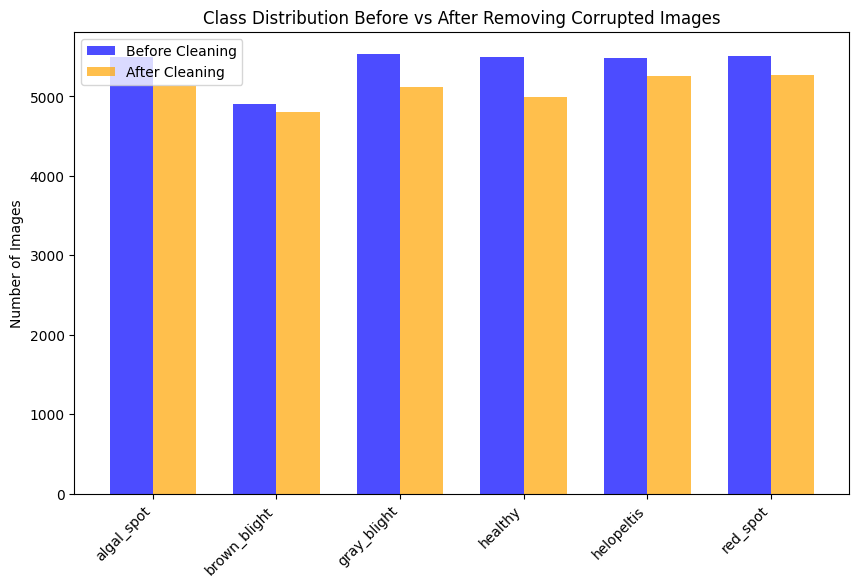

In [73]:

# --- Visualization: Before vs After ---
x = list(before_counts.keys())
before = list(before_counts.values())
after = [after_counts[k] for k in x]

x_pos = np.arange(len(x))  # numeric positions for classes
bar_width = 0.35           # width of each bar

plt.figure(figsize=(10,6))
plt.bar(x_pos - bar_width/2, before, width=bar_width, label="Before Cleaning", alpha=0.7, color='blue')
plt.bar(x_pos + bar_width/2, after, width=bar_width, label="After Cleaning", alpha=0.7, color='orange')

plt.xticks(x_pos, x, rotation=45, ha="right")
plt.title("Class Distribution Before vs After Removing Corrupted Images")
plt.ylabel("Number of Images")
plt.legend()
plt.show()